# Lecture 4 : Convolutional Neural Networks
### Please access this notebook at: https://github.com/sangaer/PracticalMachineLearning2019

In today's course, we'll cover 3 labs:
- Lab1. Recap for Neural Network
- Lab2. Convolutional Neural Network
- Lab3. Transfer learning by Using a Pre-trained Model

## Package Import
----
Import the required package, including numpy, tensorflow, and matplotlib

In [1]:
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset Preparation
----
Download dataset from kaggle `tongpython/cat-and-dog`, then divided into training, validation, and testing set:
- **Training Set**  
    A set of examples used for learning the model parameters (i.e., **weights** or **bases**) of the classifier.

    The pair of data and corresponded label are expressed as variable (`X_train`, `Y_train`)
- **Validation Set**  
    A set of examples used for the parameter tuning. Notice that the term "parameter" here denotes the architecture of the model (e.g., Number of hidden layers, number of units in a layer ., etc.), instead of the model parameters.

    The pair of data and corresponded label are expressed as variable (`X_val`, `Y_val`)
- **Testing Set**  
    A set of examples used for performance evaluation only.

    The pair of data and corresponded label are expressed as variable (`X_test`, `Y_test`)

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

 96%|██████████████████████████████████████▎ | 209M/218M [00:07<00:00, 16.9MB/s]
100%|████████████████████████████████████████| 218M/218M [00:07<00:00, 30.8MB/s]


In [3]:
def dataset_parse(folders, size=(32, 32)):
    if isinstance(folders, str):
        folders = [folders, ]

    X, Y = [], []
    for folder in folders:
        for root, dirs, files in os.walk(folder):
            for f in filter(lambda x: x.endswith('.jpg'), files):
                img = tf.keras.preprocessing.image.load_img(os.path.join(root, f), target_size=size)
                img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
                
                label = os.path.basename(root)
                
                X.append(img)
                Y.append(1 if label == 'cats' else 0)
    return np.array(X), np.array(Y, dtype='uint')

In [4]:
data_test ='test_set/test_set/'
data_train ='training_set/training_set/'

X32, Y32 = dataset_parse([data_test, data_train], size=(32, 32))

i = 9000
j = 9200
X_train, X_val, X_test = X32[:i, :], X32[i:j, :], X32[j:, :]
Y_train, Y_val, Y_test = Y32[:i], Y32[i:j], Y32[j:]

print('Shape of data:')
display([X_train.shape, X_val.shape, X_test.shape])

print('Shape of label:')
display([Y_train.shape, Y_val.shape, Y_test.shape])

Shape of data:


[(9000, 32, 32, 3), (200, 32, 32, 3), (828, 32, 32, 3)]

Shape of label:


[(9000,), (200,), (828,)]

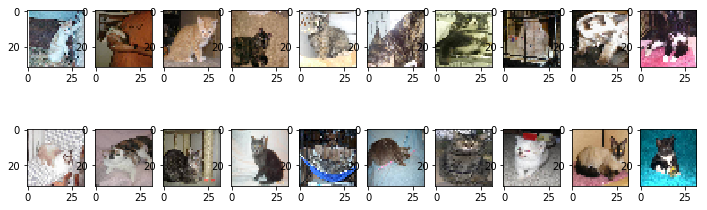

In [5]:
plt.figure(figsize=(12, 4))
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i, :])

In [6]:
# Flatten (32, 32, 3) to the 3072-dimension vector for subsequent usage
X_train = np.array([x.flatten() for x in X_train])
X_val = np.array([x.flatten() for x in X_val])
X_test = np.array([x.flatten() for x in X_test])

## Lab 1. Recap for Neural Network
----
In this section, we will recap the properties of layers introduced in week1-3. Afterward, you will be asked to finish the following task for the `cat-and-dog` dataset training:
1. Compose a Keras/Tensorflow **sequential** model
2. Compose a Keras/Tensorflow **functional** model

In this example, we construct both types of model by adding 4 fully-connected layer, which is a **Multi-Layer Perceptron** model.

### Sequential Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              67584     
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 8,464,386
Trainable params: 8,464,386
Non-trainable params: 0
_________________________________________________________________


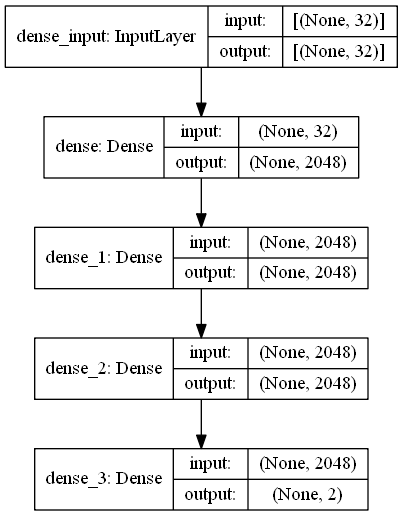

In [7]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, input_shape=(X_train.shape[1], ), activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Functional Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 14,690,306
Trainable params: 14,690,306
Non-trainable params: 0
_________________________________________________________________


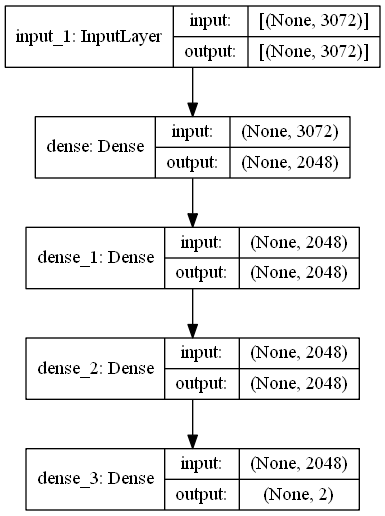

In [8]:
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(3072,))
layer = tf.keras.layers.Dense(2048, activation='relu') (inputs)
layer = tf.keras.layers.Dense(2048, activation='relu') (layer)
layer = tf.keras.layers.Dense(2048, activation='relu') (layer)
outputs = tf.keras.layers.Dense(2, activation='softmax') (layer)

optimizer = tf.keras.optimizers.Adam(lr=1e-4)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

Before we start training, here's something you already know from your hand-crafted neural network on week 2:
### Recap 1. Basics of Neural Network
---
In the neural network, **layers** served as a role of learning the knowledge, the common statistic patterns, or features from your training data. Each layer is responsible for predict the properties from the input, and then generate an output with the interesting properties with respect to the target problem.

Different layer types provide the different capabilities of agglomerating statistics characteristics from input data. For example, the **Dense layer** (also known as a fully connected layer in most textbooks) of Keras and Tensorflow takes the whole input data into considerations, evaluates its similarity to the model weights across all dimensions, and generates the output to the next layer.

To train the model parameters of these layers in order to fit into the target problem from the training data, the first-order derivative of the loss function with respect to the model parameters are required to be evaluated during the training. Take the Dense layer, for example, the loss function of each neuron in the Dense layer with respect to the model parameter $\mathbf{w}$ can be written in the following form:
$$
J\left(\mathbf{w}\right) = \sum_{\mathbf{x}\in Y}\delta_{\mathbf{x}} \mathbf{w}^T \mathbf{x}
$$

Here, $\mathbf{x} \in Y$ denotes the incorrectly handled sample. To minimize the loss function $J\left(\mathbf{w}\right)$, a good $\mathbf{w}$ can be found via gradient descent optimization:
$$
\mathbf{w}_{\text{new}} \gets \mathbf{w} - \mu\cdot\frac{\partial J\left(\mathbf{w}\right)}{\partial\mathbf{w}}
$$

which requires evaluating the first-order derivative during the back-propagation (i.e., training) procedures:
$$
\frac{\partial J\left(\mathbf{w}\right)}{\partial\mathbf{w}} = \sum_{\mathbf{x}\in Y}\delta_{\mathbf{x}} \mathbf{x}
$$


In addition to the **Dense** layer, we'll also covers **Convolutional Layer**, **Pooling Layer**, **Dropout Layer**, and **Batch Normalization Layer** today.

### Recap 2. Activation Layers
---
An activation function in the neural network architecture served as a role to determine if the particular neuron should be activated or not. In the multi-layer neural network architecture, it is also an important part to provide the ability to describe the non-linear distributed data. Basically, the activation function usually thresholds the input value $x$ to the range of $[0, x]$, $[0,1]$ or $[-1, 1]$ in order to guarantee the training stability. Ideally, a step function can be served as an activation function:
$$
\sigma\left(x\right) = \left\{
    \begin{array}{ll}
        1 \text{, if } \mathbf{x} \geq 0 \\
        0 \text{, otherwise}
    \end{array}
\right.
$$

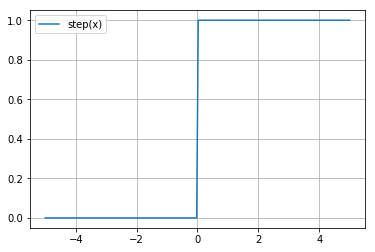

In [9]:
x = np.linspace(-5, 5, 200).reshape(-1, 1)
y = [0 if x_ <= 0 else 1 for x_ in x]

plt.plot(x, y, label='step(x)')
plt.grid()
plt.legend()
plt.show()

However, since there's **no first-order derivative** for the step function, the gradients cannot be evaluated, which makes the step function cannot be used in the neural network architecture. The differentiable function which provides similar capability is something required.

#### Sigmoid (Logistic) Layer
The sigmoid function, also known as logistic function, uses an Euler number to reaches a similar result of the step function. Severed as an activation layer in neural network architecture, it can be written in the following form:
- Feed-forward:  
    $$\sigma_s(x) = \frac{1}{1+e^{-x}}$$
- Gradients:  
    $$\frac{\partial\sigma_s(x)}{\partial x} = \sigma(x)(1-\sigma(x))$$

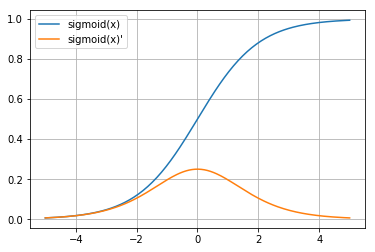

In [10]:
x = np.linspace(-5, 5, 200).reshape(-1, 1)

y = tf.keras.backend.eval(tf.keras.activations.sigmoid(x))
y = np.array(y).flatten()

y_= y*(1-y)

plt.plot(x, y, label='sigmoid(x)')
plt.plot(x, y_, label='sigmoid(x)\'')
plt.grid()
plt.legend()
plt.show()

#### ReLU Layer
With a simplified form, the Rectified Linear Unit, can be written in the following form:  
- Feed-forward:
    $$
    \sigma_R\left(x\right) = \left\{
        \begin{array}{ll}
            x \text{, if } \mathbf{x} \geq 0 \\
            0 \text{, otherwise}
        \end{array}
    \right.
    $$
- Gradients:
    $$
    \frac{\partial\sigma_R(x)}{\partial x} = \left\{
        \begin{array}{ll}
            1 \text{, if } \mathbf{x} \geq 0 \\
            0 \text{, otherwise}
        \end{array}
    \right.
    $$

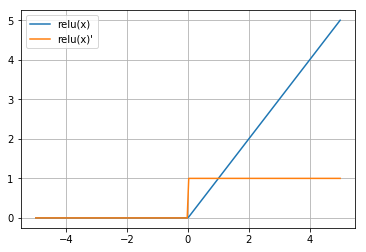

In [11]:
x = np.linspace(-5, 5, 200).reshape(-1, 1)

y = tf.keras.backend.eval(tf.keras.activations.relu(x))
y = np.array(y).flatten()

y_= np.zeros(x.shape)
y_[x > 0] = 1
y_[x <= 0] = 0

plt.plot(x, y, label='relu(x)')
plt.plot(x, y_, label='relu(x)\'')
plt.grid()
plt.legend()
plt.show()

> **Sigmoid vs. ReLU?**  
> The ReLU function is one of the most widely used activation function in many neural network-based models. Not only because of its simplifications which reduces the computational cost, but there's also some advantages compared with the Sigmoid:
> - ReLU creates sparsity, leading the non-activated elements as 0, which is a nice property because only limited neurons are expected to be stimulated in the neural network. The Sigmoid, however, leads a lot of non-zero elements even though the input is relatively small or relatively large
> - Sigmoid causes gradient vanishing problem. When the input is far from the threshold, the gradient then soon drops close to 0, which makes the neural network hard to be trained. The ReLU, however, contains a constant gradient.

#### Softmax Layer
A softmax activation function evaluates the activation by normalizing all elements from the input vectors, then generates probabilistic results which summed up to 1. Considering with the input $\mathbf{x}$, the probability that $\mathbf{x}$ belongs to the class $k$ can be written in the following form:
$$
P\left(y=k | \mathbf{x} \right) = \frac{\exp\left(\mathbf{w}_k^T\mathbf{x}\right)}{\sum_{j=1}^{K}\exp\left(\mathbf{w}_j^T\mathbf{x}\right)}
$$
Notice that comparing to the sigmoid and ReLU function, which only takes value into consideration, the softmax considers all elements from the input vectors for normalization purposes. Therefore, the softmax function is usually used for the **multi-class classification** task. In addition, due to its native behavior of normalization, and the vector squashing (i.e., thresholding the input value in the range of $[0,1]$), the softmax is NOT suggested to be used as an output of multi-label multiclass classifications.

### Recap 3. Loss Function
---
In the neural network architecture, the loss function evaluates how good the output generated by the machine learning model is. More generally, the loss function is the differences between **expected (actual) output** and the **predicted output**.

Notice that for the following code snippet:
```python
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
```

**DO NOT** get confused with loss function and accuracy function, even though it looks like both of them can be used for evaluating the model performance. Here are some major differences:
- **The loss function is for computers**  
    The choice of loss function affects the performance of the training procedure since the loss and gradients are required to be back-propagated into the layers in the fronts in order to fine-tune the model parameters. Differences in the loss value are only relative to the current task. One CANNOT judge the performance of the model by the range of the loss function
- **The accuracy function is for human**  
    The choice of accuracy function does NOT affect the performance of the training procedure. The model performance can be evaluated by human via this metrics.

---
Now, we can start training, observing the training loss and validation loss.

In [12]:
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), batch_size=64, shuffle=True)

Train on 9000 samples, validate on 200 samples
Epoch 1/20
9000/9000 [==============================] - 2s 203us/sample - loss: 0.6783 - acc: 0.5867 - val_loss: 0.6540 - val_acc: 0.6450
Epoch 2/20
9000/9000 [==============================] - 1s 163us/sample - loss: 0.6501 - acc: 0.6149 - val_loss: 0.8327 - val_acc: 0.3750
Epoch 3/20
9000/9000 [==============================] - 1s 161us/sample - loss: 0.6330 - acc: 0.6328 - val_loss: 0.8041 - val_acc: 0.4100
Epoch 4/20
9000/9000 [==============================] - 1s 161us/sample - loss: 0.6197 - acc: 0.6514 - val_loss: 0.5485 - val_acc: 0.7650
Epoch 5/20
9000/9000 [==============================] - 1s 162us/sample - loss: 0.6086 - acc: 0.6628 - val_loss: 0.9843 - val_acc: 0.3250
Epoch 6/20
9000/9000 [==============================] - 1s 161us/sample - loss: 0.5920 - acc: 0.6782 - val_loss: 0.5589 - val_acc: 0.7150
Epoch 7/20
9000/9000 [==============================] - 2s 168us/sample - loss: 0.5799 - acc: 0.6842 - val_loss: 0.8374 - val

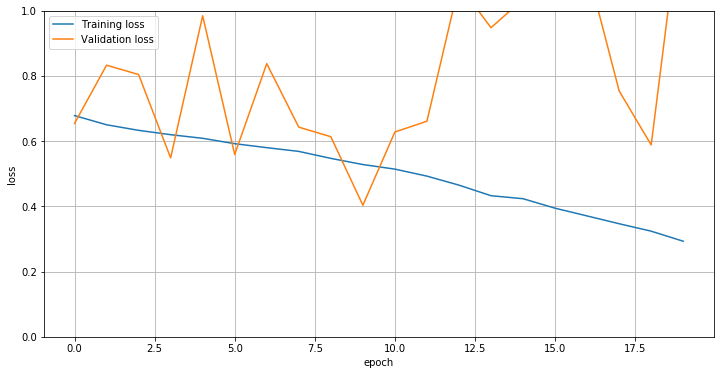

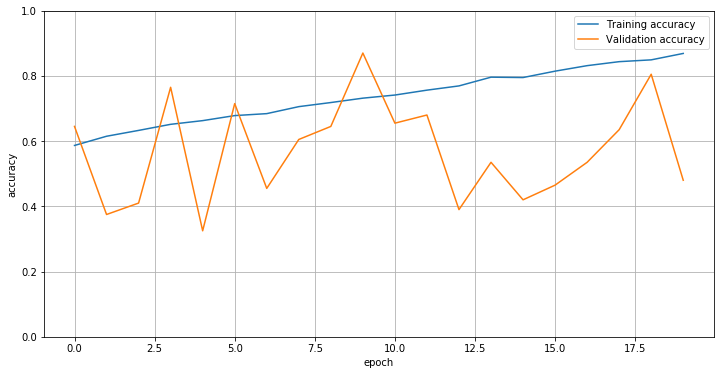

In [13]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

### Recap 4. Over-fitting vs. Under-fitting
----
Read the slide **week4.pptx** for more details.

## Lab 2. Convolutional Neural Network
----
With the convolutional layer, we can have a much larger size of the input. Let's prepare for the dataset first:

In [14]:
data_test ='test_set/test_set/'
data_train ='training_set/training_set/'

X160, Y160 = dataset_parse([data_test, data_train], size=(160, 160))

i = 9000
j = 9200
X_train, X_val, X_test = X160[:i, :], X160[i:j, :], X160[j:, :]
Y_train, Y_val, Y_test = Y160[:i], Y160[i:j], Y160[j:]

print('Shape of data:')
display([X_train.shape, X_val.shape, X_test.shape])

print('Shape of label:')
display([Y_train.shape, Y_val.shape, Y_test.shape])

Shape of data:


[(9000, 160, 160, 3), (200, 160, 160, 3), (828, 160, 160, 3)]

Shape of label:


[(9000,), (200,), (828,)]

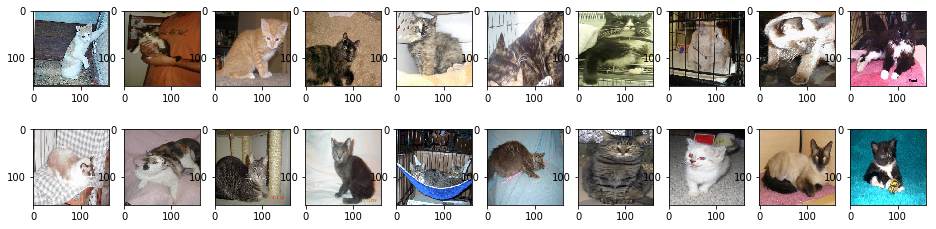

In [15]:
plt.figure(figsize=(16, 4))
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i, :])

### More Layers
----
In the [Recap 1](#Recap-1.-General-Layers) and [Recap 2](#Recap-2.-Activation-Layers), we've talk about the Dense layer and activation layer. Now we're going to talk more different type of layers:

#### Convolutional Layer
Read the slide **week4.pptx** for more details.

#### Pooling Layer
The pooling layer progressively reduces the spatial size of the representation. In the meanwhile, the number of parameters and computation in the network are also reduced. Typically there are 2 types of pooling: **max pooling** and **average pooling**.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 16)        2

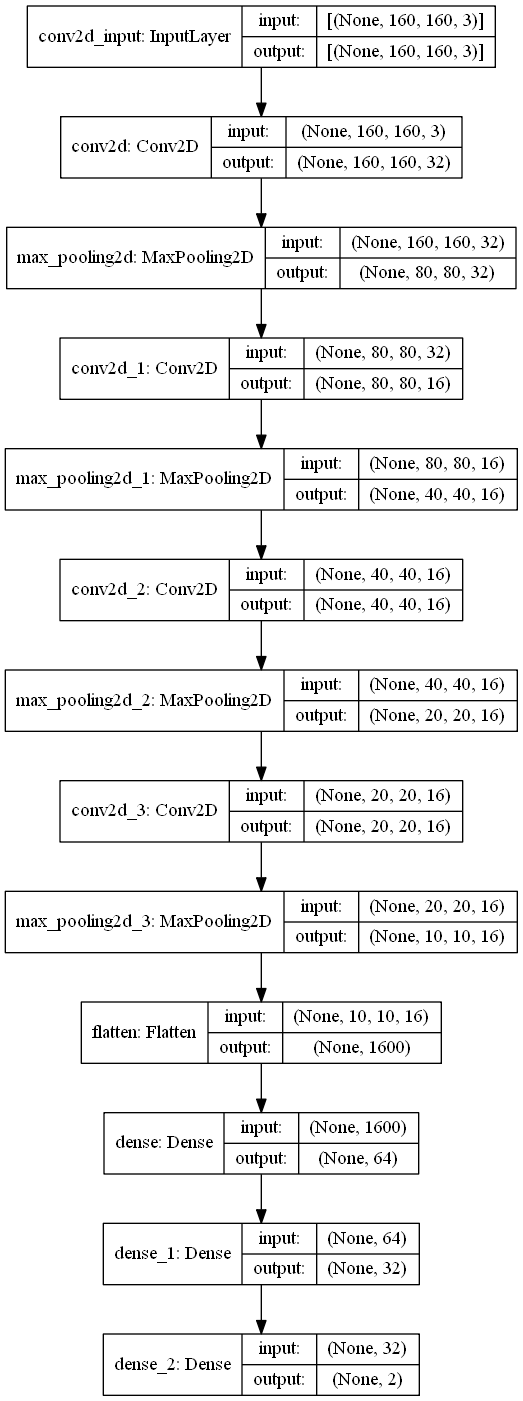

In [16]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [17]:
history = model.fit(X_train, Y_train, epochs=40, validation_data=(X_val, Y_val), batch_size=64, shuffle=True)

Train on 9000 samples, validate on 200 samples
Epoch 1/40
9000/9000 [==============================] - 11s 1ms/sample - loss: 0.6849 - acc: 0.5549 - val_loss: 0.7876 - val_acc: 0.0000e+00
Epoch 2/40
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6655 - acc: 0.5830 - val_loss: 0.6393 - val_acc: 0.6950
Epoch 3/40
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6234 - acc: 0.6562 - val_loss: 0.6847 - val_acc: 0.5750
Epoch 4/40
9000/9000 [==============================] - 9s 989us/sample - loss: 0.5904 - acc: 0.6819 - val_loss: 0.9048 - val_acc: 0.4250
Epoch 5/40
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5675 - acc: 0.7052 - val_loss: 0.7706 - val_acc: 0.5400
Epoch 6/40
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5477 - acc: 0.7226 - val_loss: 0.7653 - val_acc: 0.5200
Epoch 7/40
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5334 - acc: 0.7308 - val_loss: 0.5087 - val_acc: 0

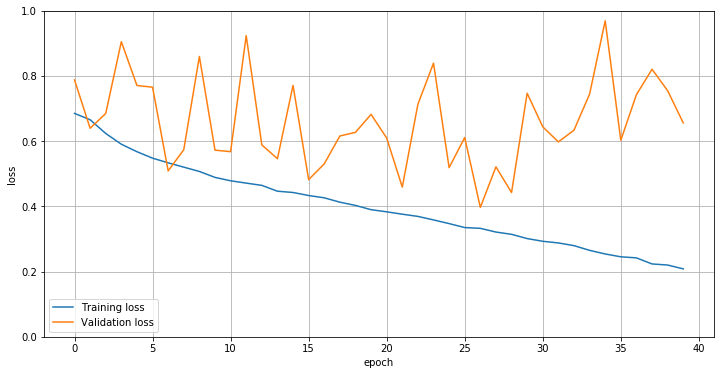

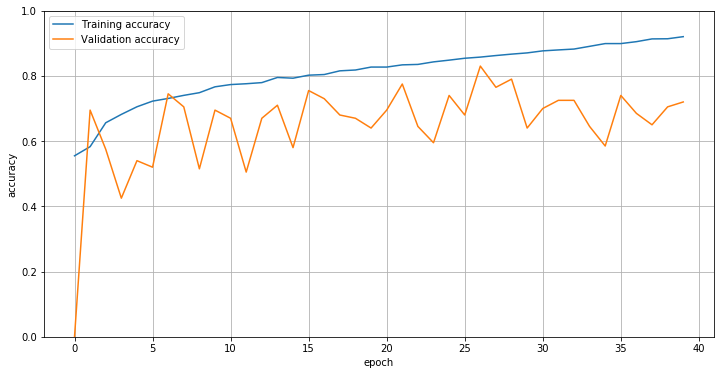

In [18]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

In addition to the Convolutional layer and pooling layer, the following layer types also play important roles in enhancing the training stability, preventing the over-fitting, and increasing the speed of convergence:

#### Dropout Layer
The dropout layer randomly masked out particular neurons. During the training procedures, the neuron is only kept active when its probability is higher than $p$. Otherwise, set it to 0.

The randomness properties of the dropout layer prevent the attached layers always fit into particular parts of the input data.

Notice that:
- DO NOT place the dropout layer as the last layer of the neural network architecture, since it is not make sense to randomly mask the prediction result of some neurons.
- The dropout layer prevents over-fitting only when the model capacity is sufficiently higher than the diversity of the data distributions. If the model capacity is not sufficient, the training performances would be dropped.
- The dropout layer usually requires more epochs to reach the convergence.

Now let's train with dropout layer added:

In [19]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 16)        0

In [20]:
history = model.fit(X_train, Y_train, epochs=60, validation_data=(X_val, Y_val), batch_size=64, shuffle=True)

Train on 9000 samples, validate on 200 samples
Epoch 1/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.6883 - acc: 0.5531 - val_loss: 0.7299 - val_acc: 0.0300
Epoch 2/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6782 - acc: 0.5764 - val_loss: 0.7554 - val_acc: 0.2150
Epoch 3/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6556 - acc: 0.6142 - val_loss: 0.6410 - val_acc: 0.6650
Epoch 4/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6347 - acc: 0.6377 - val_loss: 0.6577 - val_acc: 0.5300
Epoch 5/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6179 - acc: 0.6541 - val_loss: 0.6703 - val_acc: 0.5100
Epoch 6/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.6090 - acc: 0.6634 - val_loss: 0.7320 - val_acc: 0.4550
Epoch 7/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5933 - acc: 0.6790 - val_loss: 0.7024 - val_acc: 0.5200


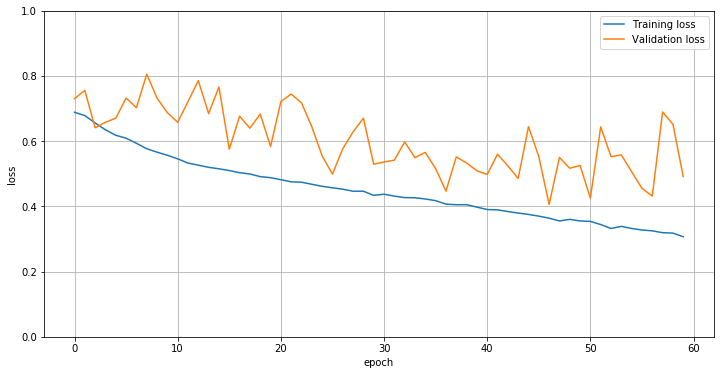

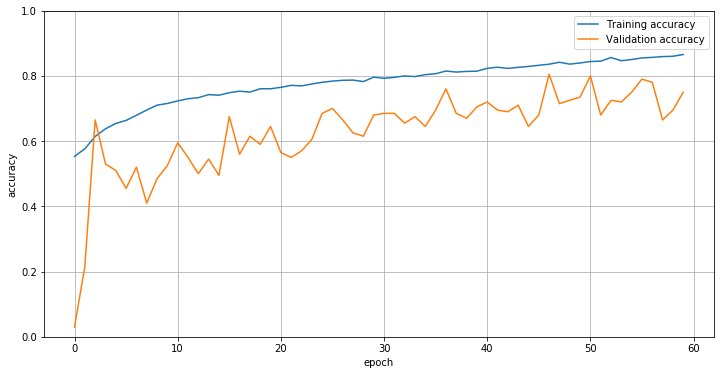

In [21]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

#### Batch Normalization Layer
Batch normalization layer fetches a group of data from the output of previous attached layer, centraling the value by minus the mean value $\mu$, then divided by the variance $\sigma$:
$$
\tilde{x}_i = \frac{x_i - \mu}{\sigma}
$$
where $\mu = \frac{1}{M} \sum_{i=1}^{M} x_i $, and $\sigma=\sqrt{\frac{1}{M} \sum_{i=1}^M \left(x_i - \mu\right)^2}$.

Batch normalization resolves the saturation gradient for some activation function like **hyperbolic tangent** (tanh) and **sigmoid**. In other words, the training times can be reduced and a deep network architecture can be trainable.

Notice that the batch size should be large enough. Mean and variances of small batch cannot reflect the data distributions.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 16)        0

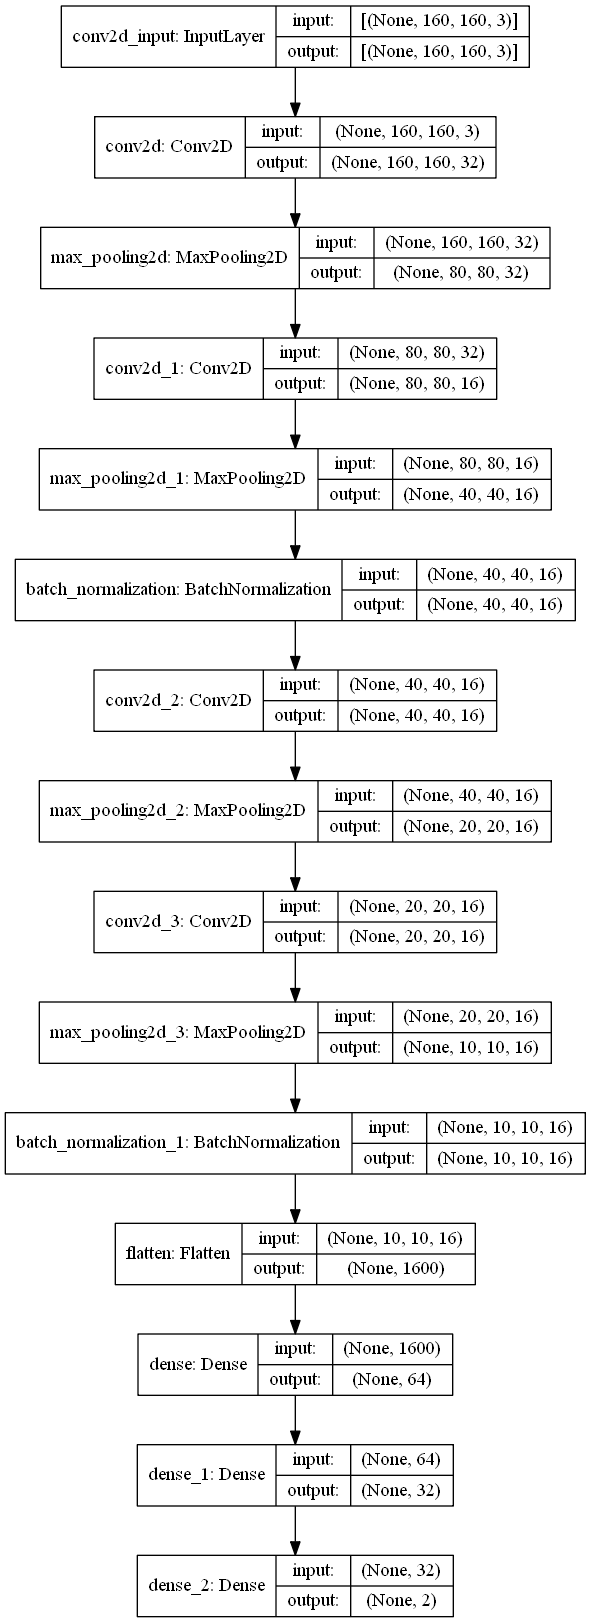

In [22]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
loss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [23]:
history = model.fit(X_train, Y_train, epochs=60, validation_data=(X_val, Y_val), batch_size=64, shuffle=True)

Train on 9000 samples, validate on 200 samples
Epoch 1/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.6911 - acc: 0.5930 - val_loss: 1.2281 - val_acc: 0.0000e+00
Epoch 2/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.5986 - acc: 0.6716 - val_loss: 1.6609 - val_acc: 0.0000e+00
Epoch 3/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5463 - acc: 0.7264 - val_loss: 1.4690 - val_acc: 0.1150
Epoch 4/60
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.5016 - acc: 0.7592 - val_loss: 0.9448 - val_acc: 0.4250
Epoch 5/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.4592 - acc: 0.7896 - val_loss: 0.8286 - val_acc: 0.5700
Epoch 6/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.4220 - acc: 0.8122 - val_loss: 0.6905 - val_acc: 0.6400
Epoch 7/60
9000/9000 [==============================] - 10s 1ms/sample - loss: 0.3868 - acc: 0.8344 - val_loss: 0.6632 - val_

9000/9000 [==============================] - 9s 1ms/sample - loss: 0.0105 - acc: 0.9976 - val_loss: 1.6697 - val_acc: 0.7050


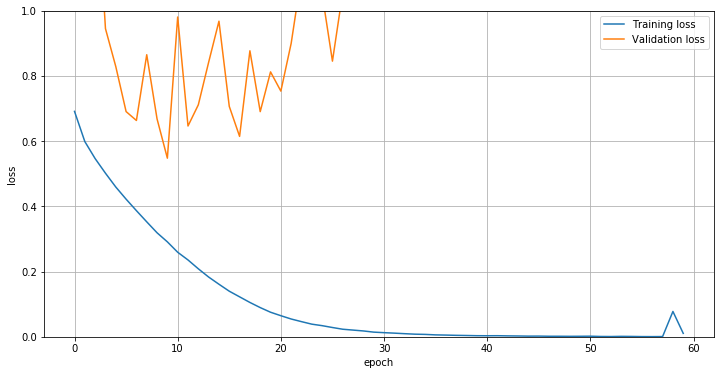

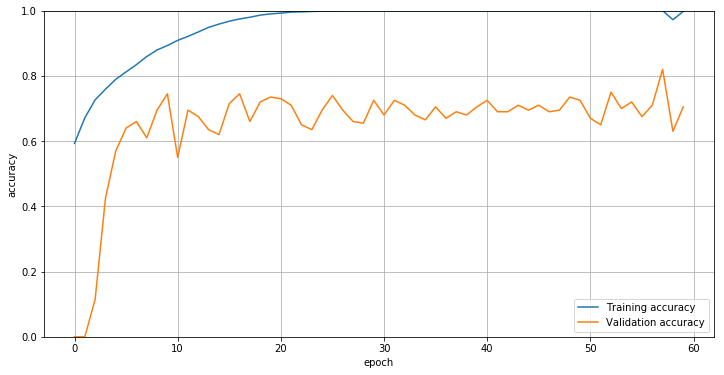

In [24]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

For more information, check **week4.pptx**. Also, check following materials for more details:
- http://cs231n.github.io/neural-networks-2/
- http://cs231n.github.io/convolutional-networks

## Lab 3. Transfer Learning with Pre-trained Model
----

Based on the [tensorflow's official documents](https://www.tensorflow.org/tutorials/images/transfer_learning):
> A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as it is, or use transfer learning to customize this model to a given task.
> 
> The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

https://www.tensorflow.org/api_docs/python/tf/keras/applications

Now let's look at the original MobileNetV2's performance, trained on 14 million images of ImageNet:

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

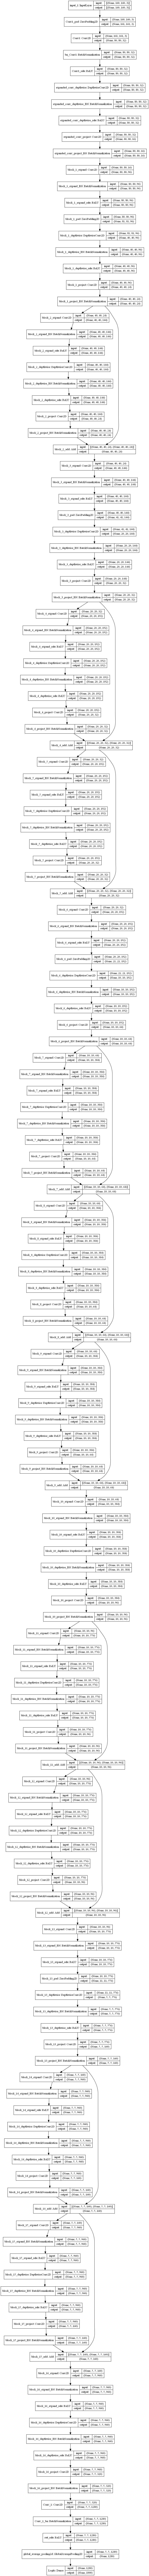

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=True, weights='imagenet')
base_model.summary()
tf.keras.utils.plot_model(base_model, show_layer_names=True, show_shapes=True)

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02093428', 'American_Staffordshire_terrier', 0.32087407), ('n02093256', 'Staffordshire_bullterrier', 0.15380722), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.08957668), ('n02089867', 'Walker_hound', 0.031476293), ('n02107908', 'Appenzeller', 0.029862165)]


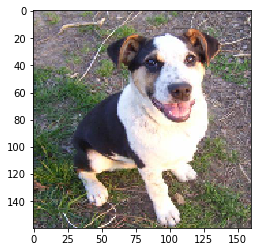

In [26]:
Y_test_predict = base_model.predict(X_test)

plt.imshow(X_test[0, :])
print('Predicted:', tf.keras.applications.mobilenet_v2.decode_predictions(Y_test_predict, top=5)[0])

In [27]:
layer = base_model.layers[-2].output
layer = tf.keras.layers.Dense(32, activation='relu') (layer)
layer = tf.keras.layers.Dense(2, activation='softmax') (layer)

model_transfer_learning = tf.keras.models.Model(inputs=base_model.input, outputs=layer)

for layer in model_transfer_learning.layers[:-2]:
    layer.trainable = False

model_transfer_learning.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model_transfer_learning.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [28]:
history = model_transfer_learning.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), batch_size=32, shuffle=True)

Train on 9000 samples, validate on 200 samples
Epoch 1/20
9000/9000 [==============================] - 16s 2ms/sample - loss: 0.2012 - acc: 0.9174 - val_loss: 0.7963 - val_acc: 0.7050
Epoch 2/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.1226 - acc: 0.9516 - val_loss: 0.7081 - val_acc: 0.7750
Epoch 3/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.1185 - acc: 0.9508 - val_loss: 0.3957 - val_acc: 0.8600
Epoch 4/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.1079 - acc: 0.9568 - val_loss: 0.6114 - val_acc: 0.7750
Epoch 5/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.0948 - acc: 0.9632 - val_loss: 0.2680 - val_acc: 0.9050
Epoch 6/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.0869 - acc: 0.9650 - val_loss: 0.3297 - val_acc: 0.9050
Epoch 7/20
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.0806 - acc: 0.9671 - val_loss: 0.2867 - val_acc: 0

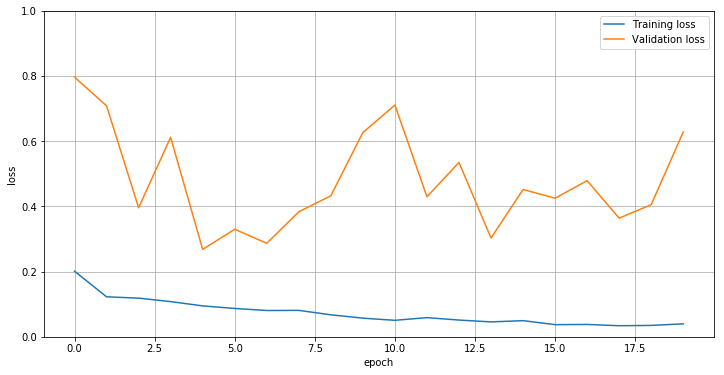

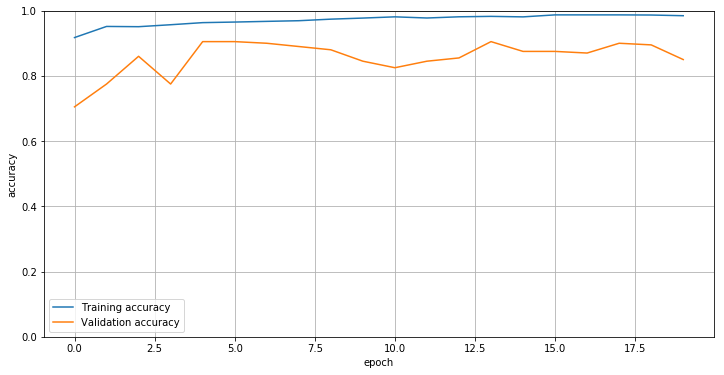

In [29]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()

plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.0, 1.0))
plt.show()


**Once finished, please Submit Your Colab Notebook [Here](https://forms.gle/Hkk7WS2BDsmwGovE8)**